# Probabilistic Roadmap


In this notebook you'll expand on previous random sampling exercises by creating a graph from the points and running A*.

1. Load the data
2. Sample nodes
3. Connect nodes
4. Visualize graph
5. Define heuristic
6. Define search method
7. Execute and visualize

We'll load the data and provide a template for visualization.

In [1]:
# Again, ugly but we need the latest version of networkx!
# This sometimes fails for unknown reasons, please just 
# "reset and clear output" from the "Kernel" menu above 
# and try again!
import sys
!{sys.executable} -m pip install -I networkx==2.1
import pkg_resources
pkg_resources.require("networkx==2.1")
import networkx as nx


  Using cached networkx-2.1-py2.py3-none-any.whl
  Using cached decorator-5.1.1-py3-none-any.whl (9.1 kB)


In [2]:
nx.__version__ # should be 2.1

'2.1'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sampling import Sampler
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue
import pickle
%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = 12, 12

## Step 1 - Load Data

In [5]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


## Step 2 - Sample Points

We've implemented a custom sampling class using a k-d tree.

In [6]:
from sampling import Sampler

In [7]:
safety_distance=5
sampler = Sampler(data,safety_distance)
polygons = sampler._polygons

In [8]:
# Example: sampling 100 points and removing
# ones conflicting with obstacles.
nodes = sampler.sample(1000)
print(len(nodes))

488


In [9]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
#north_min = np.floor(np.min(data[:, 0] - data[:, 3]))
#east_min = np.floor(np.min(data[:, 1] - data[:, 4]))
sampler = Sampler(data,safety_distance)
polygons = sampler._polygons
goal_rnd=[]
while len(goal_rnd)==0:
    goal_rnd = sampler.sample(1)
goal_pos=goal_rnd[0]
goal_pos

(314.405918020192, 448.31751445077794, 15.809636428499918)

### start and goal

In [9]:
goal_rnd=[]
len(goal_rnd)

0

In [10]:

goal_rnd=[]
while len(goal_rnd)==0:
    goal_rnd = sampler.sample(1)

goal_rnd=goal_rnd[0]
print (goal_rnd)

(552.5641084553215, -262.00354040389624, 9.037666895697836)


## Step 3 - Connect Nodes

Now we have to connect the nodes. There are many ways they might be done, it's completely up to you. The only restriction being no edge connecting two nodes may pass through a polygon.

NOTE: You can use `LineString` to create a line. Additionally, `shapely` geometry objects have a method `.crosses` which return `True` if the geometries cross paths.

In [11]:
def closest_neighbor(graph,point,polygons):
    #ientifying closest point in the graph from start and goal
    closest_neighbor=None
    distance=1000
    for coordinate in graph.nodes:
        dist=LA.norm(np.array(coordinate) - np.array(point))
        if dist < distance:
            if can_connect(point, coordinate ,polygons):
                closest_neighbor=coordinate
                distance=dist
    return closest_neighbor

In [12]:
import numpy.linalg as LA
from sklearn.neighbors import KDTree

In [13]:
def can_connect(n1, n2,polygons):
    l = LineString([n1, n2])
    for p in polygons:
        if p.crosses(l) and p.height >= min(n1[2], n2[2]):
            return False
    return True

def create_graph(nodes, k, polygons):
    g = nx.Graph()
    tree = KDTree(nodes)
    for n1 in nodes:
        # for each node connect try to connect to k nearest nodes
        idxs = tree.query([n1], k, return_distance=False)[0]
        
        for idx in idxs:
            n2 = nodes[idx]
            if n2 == n1:
                continue
                
            if can_connect(n1, n2, polygons):
                g.add_edge(n1, n2, weight=1)
    return g

In [14]:
import time
t0 = time.time()
g = create_graph(nodes, 10,polygons)
print('graph took {0} seconds to build'.format(time.time()-t0))

graph took 92.45473790168762 seconds to build


In [15]:
print("Number of edges", len(g.edges))

Number of edges 1457


In [16]:
list(g.nodes)[0]

(-39.84303951954064, 313.3662227899049, 18.191608497962243)

## Step 3.5 Saving Graph

In [17]:
nx.write_gpickle(g, "graph.gpickle")

## Step 4 - Visualize Graph

In [143]:
from grid import create_grid

In [144]:
grid = create_grid(data, sampler._zmax, 1)

-310.2389
-439.2315


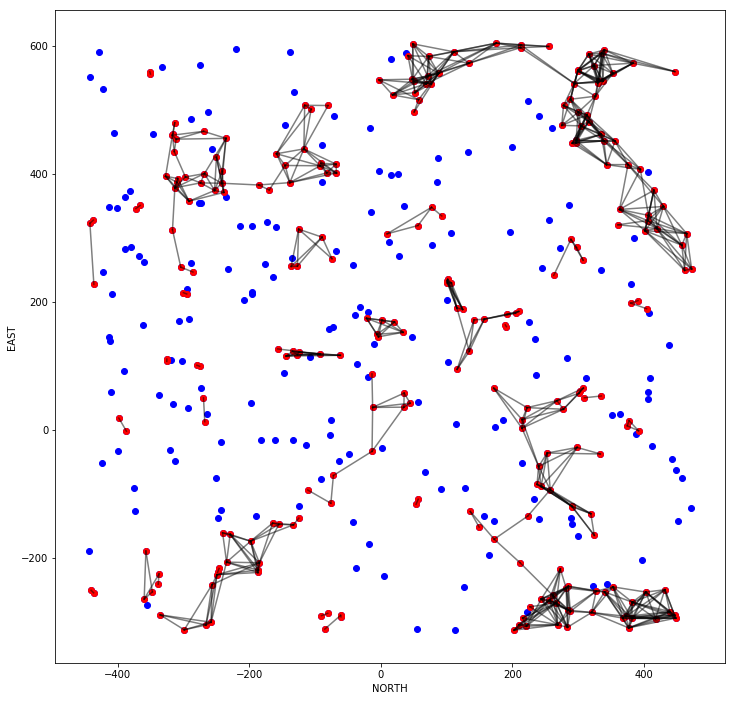

In [145]:
fig = plt.figure()

#plt.imshow(grid, cmap='Greys', origin='lower')

nmin = 0
print(np.min(data[:, 0]))
emin = 0
print(np.min(data[:, 1]))

# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)

# draw all nodes
for n1 in nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# draw connected nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')

 
    


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

## Step 5 - Define Heuristic

In [87]:
def heuristic(n1, n2):
    # TODO: finish
    return LA.norm(np.array(n2) - np.array(n1))

In [88]:
goal_rnd=[]
while len(goal_rnd)==0:
    goal_rnd = sampler.sample(1)
goal_rnd=goal_rnd[0]
print (goal_rnd)

(-312.8922652119318, -72.04985264927677, 4.031465466232083)


In [89]:
start_pos=-10,-13,0
start_pos_graph=closest_neighbor(g,start_pos,polygons)
goal_pos_graph=closest_neighbor(g,goal_rnd,polygons)
print(start_pos,start_pos_graph,goal_pos_graph, goal_rnd)

(-10, -13, 0) (3.0362811131813032, 12.382334067990996, 11.983352941086679) None (-312.8922652119318, -72.04985264927677, 4.031465466232083)


## Step 6 - Complete A*

In [90]:
def a_star(graph, heuristic, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    # TODO: complete

    path = []
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    i=0
    while not queue.empty():
        i=i+1
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]
        print("finding path {}".format(i))

        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + heuristic(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))
                    
                    branch[next_node] = (new_cost, current_node)
             
    path = []
    path_cost = 0
    if found:
        
        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print ("No path found")
            
    return path[::-1], path_cost

In [91]:
path, cost = a_star(g, heuristic, start_pos_graph, goal_pos_graph)
path.append((goal_rnd))
print(len(path), path)

finding path 1


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [ ]:
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    print(n1, n2)

## Step 7 - Visualize Path

In [ ]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black',lw=0.1)
    
# TODO: add code to visualize the path
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'green',lw=5)
    print(n1,n2)

plt.scatter(0,0,c="yellow")
plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

In [ ]:
fig = plt.figure()

#plt.imshow(grid, cmap='Greys', origin='lower')

nmin = 0#np.min(data[:, 0])
emin = 0#np.min(data[:, 1])

# draw nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black',lw=0.1)
    
# TODO: add code to visualize the path
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'green',lw=5)
    print(n1,n2)

plt.scatter(0,0,c="yellow")

plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()